# NDWI - Cutzamala (WIP)

* __presa_elbosque__ --> DONE. Run con cloud coverage 10
* __presa_valledebravo__ --> Multiple missing months together en cloud coverage 10, 15 y 20.
* __presa_villavictoria__ --> Multiple missing months together en cloud coverage 10, 15 y 20.

## Import libraries

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

In [23]:
# Set raster spectral bands and analysis equation
band_name_dict = {'green':[False], #If GSD(resolution) of band is different, set True.
                  'nir':[False], #If GSD(resolution) of band is different, set True.
                  'eq':["(green-nir)/(green+nir)"]}

# Set analysis name
index_analysis = 'ndwi'

# Set directory to save analysed rasters
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [10,11]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2016-01-01'
end_date = '2024-02-28'

# Save?
save = True # True

# Del rasters after processing.
del_data = False # True

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'presa_villavictoria'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
query = {"eo:cloud_cover": {"lt": 20}}

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

## Load data

### Load data - Area of interest

<Axes: >

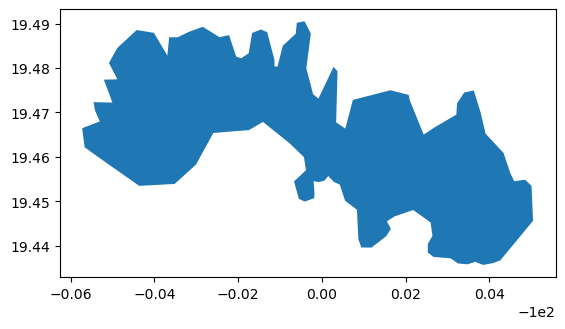

In [18]:
#Load data
presa_original = gpd.read_file("../../../data/external/temporal_todocker/{}.gpkg".format(city))
presa_original.plot()

In [19]:
#Filter for relevant data
columns_tokeep = ['Name','geometry']
presa = presa_original[columns_tokeep]

#Create buffer for dam geometry
polygon = presa.to_crs("EPSG:6372").buffer(500)
polygon = polygon.to_crs("EPSG:4326")
polygon = gpd.GeoDataFrame(geometry=polygon).dissolve().geometry

#Review result
print(polygon.shape)
polygon.head(2)

(1,)


0    POLYGON ((-100.05907 19.47061, -100.05924 19.4...
Name: geometry, dtype: geometry

### Load data - Download and process rasters

In [24]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
df_len = aup.download_raster_from_pc(polygon, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query = query, satellite = satellite)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AvailableData: Multiple missing months together

## Create hexgrid

In [12]:
res = [11]

In [13]:
poly_gdf = gpd.GeoDataFrame(polygon)
hex_gdf = gpd.GeoDataFrame()

if len(res)>1: #If there is more than one resolution
    for r in res:
        hex_tmp = aup.create_hexgrid(poly_gdf, r)
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        hex_gdf = pd.concat([hex_gdf, hex_tmp], ignore_index=True, axis=0)
        del hex_tmp

else: #If there is only one resolution
    hex_gdf = aup.create_hexgrid(poly_gdf, res[0])
    hex_gdf.rename(columns={f'hex_id_{res[0]}':'hex_id'}, inplace=True)
    hex_gdf['res'] = res[0]
    
#Show
print(hex_gdf.shape)
hex_gdf.head(2)

(7569, 3)


,hex_id,geometry,res
0,8b498636acb2fff,"POLYGON ((-100.40059 19.41165, -100.40041 19.4...",11
1,8b498636e8defff,"POLYGON ((-100.41602 19.39099, -100.41584 19.3...",11


In [14]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)

    if save:
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

In [16]:
for r in list(hex_gdf.res.unique()):

    processing_chunk = 150000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)
    
    if len(hex_gdf_res)>processing_chunk:
        c_processing = len(hex_gdf_res)/processing_chunk
        
        for i in range(int(c_processing)):
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)
    else:
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

 11%|████████████████████▉                                                                                                                                                                       | 1/9 [00:20<02:45, 20.74s/it]

 33%|██████████████████████████████████████████████████████████████▋                                                                                                                             | 3/9 [01:13<02:31, 25.32s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 5/9 [02:11<01:49, 27.36s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7/9 [03:07<00:55, 27.94s/it]

  0%|                                                                                               